#### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import requests
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer
from persian_wordcloud.wordcloud import PersianWordCloud

#### Dataset

In [ ]:
data = pd.read_json('https://raw.githubusercontent.com/modos/ML-AI/refs/heads/main/datasets/bbcpersian_news.json')

In [ ]:
data.describe()

,category,link,title,publish_time,related_topics,body
count,3780,3780,3780,3780,3780,3780
unique,43,3780,3777,777,2257,3775
top,iran,https://www.bbc.com/persian/business-53642810,پرسپولیس به یک‌چهارم نهایی لیگ قهرمانان آسیا رسید,۱۴ مرداد ۱۴۰۰ - ۵ اوت ۲۰۲۱,"[فوتبال, ورزش]",\n\n\n\n\n\n\n\n\n\n\n\n\nتمامی عکس‌ها شامل قو...
freq,754,1,2,20,218,3


#### Select Categories

In [ ]:
filtered_data = data[data.category.isin(['business', 'arts', 'sport', 'science'])]
filtered_data = filtered_data.drop(columns=["link",	"title","publish_time","related_topics"])

#### Data Distributaion

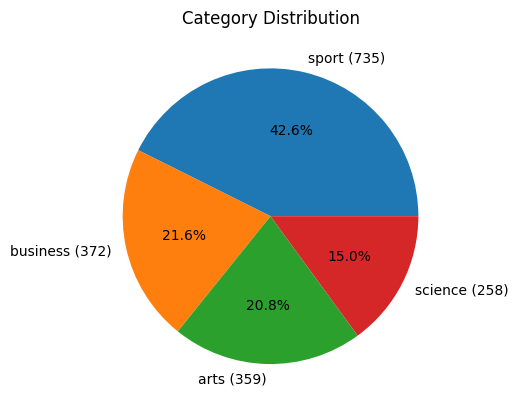

In [ ]:
category_counts = filtered_data['category'].value_counts()
labels = [f'{label} ({count})' for label, count in zip(category_counts.index, category_counts)]

plt.pie(category_counts, labels=labels, autopct='%1.1f%%')
plt.title('Category Distribution')
plt.show()

#### Remove Stopwords

In [ ]:
filtered_data['body'] = filtered_data.body.apply(lambda text: re.sub("\n", "", text))
filtered_data['body'] = filtered_data.body.apply(lambda text: re.sub("\u200c", " ", text))
filtered_data['body'] = filtered_data.body.apply(lambda text: re.sub("برای پخش این فایل لطفا جاوا اسکریپت را فعال یا از یک مرورگر دیگر استفاده کنید", "", text))
filtered_data['body'] = filtered_data['body'].str.replace(r"[0-9۰-۹]", "", regex=True)
filtered_data['body'] = filtered_data['body'].str.replace(r"[+-]", "", regex=True)
filtered_data['body'] = filtered_data['body'].str.replace(r"[a-zA-Z]", "", regex=True)

stop_word_chars = np.loadtxt('https://github.com/modos/ML-AI/raw/refs/heads/main/datasets/persian_utils/stopwords/chars.txt', dtype=str)
stop_word_chars[0] = '!'

url = 'https://raw.githubusercontent.com/modos/ML-AI/refs/heads/main/datasets/persian_utils/stopwords/verbal.txt'
response = requests.get(url)
verbals = response.text

url = 'https://raw.githubusercontent.com/modos/ML-AI/refs/heads/main/datasets/persian_utils/stopwords/nonverbal.txt'
response = requests.get(url)
nonverbals = response.text

stop_word_chars = np.concatenate((stop_word_chars, verbals.split('\n'), nonverbals.split('\n')))

def remove_stop_words(text):
  text = text.strip()
  for word in stop_word_chars:
    text = re.sub(r'(?<!\S)' + re.escape(word) + r'(?!\S)', ' ', text)
  return text

filtered_data['body'] = filtered_data['body'].apply(remove_stop_words)


#### Label Encoding

In [ ]:
le = LabelEncoder()
original_categories = filtered_data['category'].copy()
filtered_data['category'] = le.fit_transform(filtered_data['category'])

#### Create Classifier With Multinomial Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X = filtered_data['body']
y = filtered_data['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', MultinomialNB())])

nb_text_clf.fit(X_train, y_train)

predicted = nb_text_clf.predict(X_test)

accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted, average='weighted')
recall = recall_score(y_test, predicted, average='weighted')
f1 = f1_score(y_test, predicted, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.7507246376811594
Precision: 0.8439397860593513
Recall: 0.7507246376811594
F1-score: 0.7289311127816501


#### Create Classifier with SVM (SVC)

In [ ]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

X = filtered_data['body']
y = filtered_data['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svc_text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', SVC())])

svc_text_clf.fit(X_train, y_train)

predicted = svc_text_clf.predict(X_test)

accuracy = accuracy_score(y_test, predicted)
precision = precision_score(y_test, predicted, average='weighted')
recall = recall_score(y_test, predicted, average='weighted')
f1 = f1_score(y_test, predicted, average='weighted')

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-score: {f1}")

Accuracy: 0.9768115942028985
Precision: 0.9780484301406939
Recall: 0.9768115942028985
F1-score: 0.9768454107211288


#### SVC Confusion Matrix

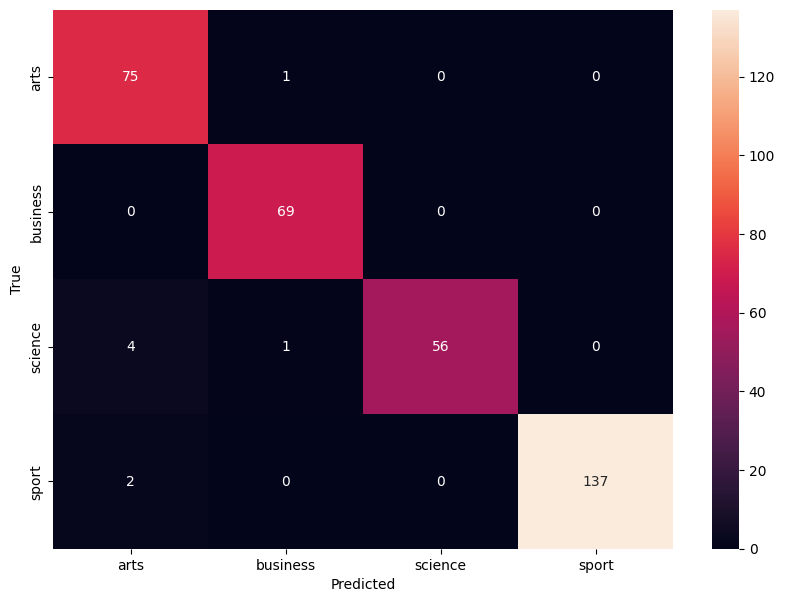

In [ ]:
cm = confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(predicted))

class_names = le.classes_

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

#### Create Classifier With ANN

In [ ]:
X = filtered_data['body']
y = filtered_data['category']

le = LabelEncoder()
y = le.fit_transform(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf = TfidfVectorizer()
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

ann_model = Sequential()
ann_model.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
ann_model.add(Dense(16, activation='relu'))
ann_model.add(Dense(y.shape[1], activation='softmax'))

ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

hist = ann_model.fit(X_train, y_train, epochs=10, batch_size=32)

loss, accuracy = ann_model.evaluate(X_test, y_test)
print(f"Accuracy: {accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.4327 - loss: 1.2359
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7486 - loss: 0.6354
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9972 - loss: 0.2932
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9996 - loss: 0.1069
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 1.0000 - loss: 0.0470
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.0228
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.0135
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 1.0000 - loss: 0.0094
Epoch 9/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 1.0000 - loss: 0.0065
Epoch 10/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 1.0000 - loss: 0.0050
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9715 - loss: 0.1381 
Accuracy: 0.9768115878105164


#### Ann Model Summary

In [ ]:
ann_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 64)                  │       2,236,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 4)                   │              68 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,713,534 (25.61 MB)

 Trainable params: 2,237,844 (8.54 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,475,690 (17.07 MB)

#### Ann Model Loss

Text(0.5, 0, 'Epoch')

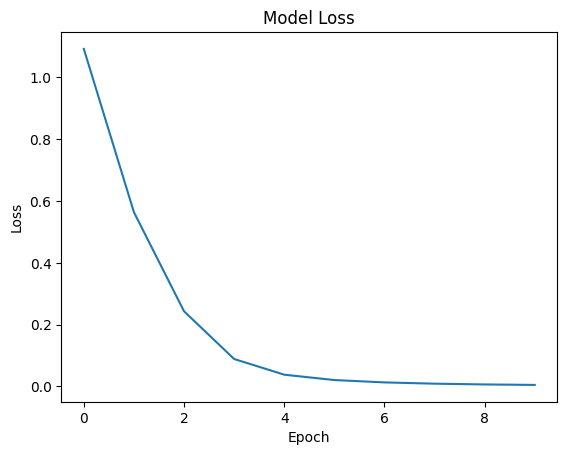

In [ ]:
plt.plot(hist.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

#### Ann Model Accuracy

Text(0.5, 0, 'Epoch')

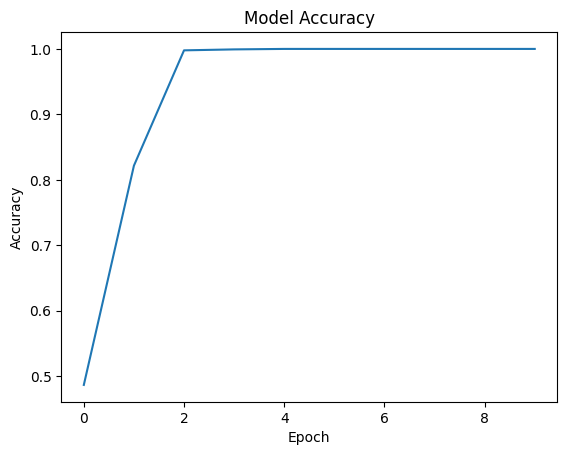

In [ ]:
plt.plot(hist.history['accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

#### Test With https://www.tasnimnews.com/ and https://tejaratnews.com/ Data

In [ ]:
tt_news_data = pd.read_csv('https://raw.githubusercontent.com/modos/ML-AI/refs/heads/main/datasets/news_tasnim_tejartnews.csv')

In [ ]:
tt_news_data['body'] = tt_news_data.body.apply(lambda text: re.sub("\n", "", text))
tt_news_data['body'] = tt_news_data.body.apply(lambda text: re.sub("\u200c", " ", text))
tt_news_data['body'] = tt_news_data.body.apply(lambda text: re.sub("برای پخش این فایل لطفا جاوا اسکریپت را فعال یا از یک مرورگر دیگر استفاده کنید", "", text))
tt_news_data['body'] = tt_news_data['body'].str.replace(r"[0-9۰-۹]", "", regex=True)
tt_news_data['body'] = tt_news_data['body'].str.replace(r"[+-]", "", regex=True)
tt_news_data['body'] = tt_news_data['body'].str.replace(r"[a-zA-Z]", "", regex=True)

stop_word_chars = np.loadtxt('https://github.com/modos/ML-AI/raw/refs/heads/main/datasets/persian_utils/stopwords/chars.txt', dtype=str)
stop_word_chars[0] = '!'

url = 'https://raw.githubusercontent.com/modos/ML-AI/refs/heads/main/datasets/persian_utils/stopwords/verbal.txt'
response = requests.get(url)
verbals = response.text

url = 'https://raw.githubusercontent.com/modos/ML-AI/refs/heads/main/datasets/persian_utils/stopwords/nonverbal.txt'
response = requests.get(url)
nonverbals = response.text

stop_word_chars = np.concatenate((stop_word_chars, verbals.split('\n'), nonverbals.split('\n')))

def remove_stop_words(text):
  text = text.strip()
  for word in stop_word_chars:
    text = re.sub(r'(?<!\S)' + re.escape(word) + r'(?!\S)', ' ', text)
  return text

tt_news_data['body'] = tt_news_data['body'].apply(remove_stop_words)


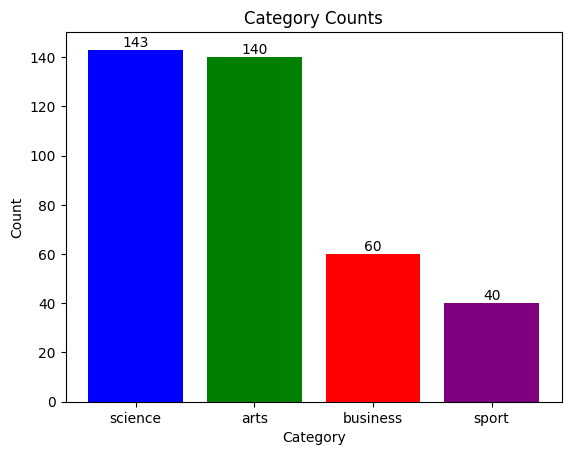

In [ ]:
plt.bar(tt_news_data['category'].value_counts().index, tt_news_data['category'].value_counts().values, color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Category Counts')

for i, v in enumerate(tt_news_data['category'].value_counts().values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.show()

In [ ]:
X_tt_test = tt_news_data['body']
y_tt_test = tt_news_data['category']

all_categories = ['business', 'arts', 'sport', 'science']
le.fit(all_categories)

X_tt_test = tfidf.transform(X_tt_test).toarray()
y_tt_test = le.transform(y_tt_test)
y_tt_test = to_categorical(y_tt_test)

loss_tt, accuracy_tt = ann_model.evaluate(X_tt_test, y_tt_test)
print(f"Accuracy: {accuracy_tt}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8345 - loss: 0.5840
Accuracy: 0.8668407201766968


#### BBC News Word Cloud

In [ ]:
wc = PersianWordCloud(width=1000, height=1000)
frequencies = wc.process_text(filtered_data['body'].str.cat(sep=' '))
word_cloud = wc.generate_from_frequencies(frequencies)
image = word_cloud.to_image()
image.show()
image.save('bbc_news_word_cloud.jpg')

### Tasnim/Tejart Word Cloud

In [ ]:
wc = PersianWordCloud(width=1000, height=1000)
frequencies = wc.process_text(tt_news_data['body'].str.cat(sep=' '))
word_cloud = wc.generate_from_frequencies(frequencies)
image = word_cloud.to_image()
image.show()
image.save('tasnim_tejarat_word_cloud.jpg')